In [1]:
# read the data

text = []

with open('mingshilu_texts.txt','r') as f:
    for line in f.read().splitlines():
        if line != '':
            text.append(line)
print 'There are',len(text),'text entries'

In [2]:
# for now, experiment with the first 10,000 entries

text = text[:5000]

# convert to unicode
for i in range(len(text)):
    text[i] = text[i].decode('utf8')

In [3]:
# extract the unique tokens

tokens_dict = {}
reverse_tokens_dict = {}

counter = 0
for document in text:
    for token in document:
        if token not in tokens_dict:
            tokens_dict[token] = counter
            reverse_tokens_dict[counter] = token
            counter += 1

print counter

4839


In [4]:
# tokenize each document

tokenized_text = []
for document in text:
    tokenized_document = []
    for token in document:
        tokenized_document.append(tokens_dict[token])
    tokenized_text.append(tokenized_document)

In [5]:
# set the priors
import numpy as np

topic_num = 50
token_num = len(tokens_dict)
doc_num = len(tokenized_text)

total_tokens = 0
for document in tokenized_text:
    total_tokens += len(document)

eta, alpha, sigma, delta = 0.01, 1, 0.1, 0.01

In [6]:
# initialize the topics and the counts

topics = {}
topical_status = {}
# how many times word w is assigned into topic z as a unigram
n_zw = np.zeros((topic_num, token_num))
# how many times word w is assigned to non-topic word
m_w = np.zeros(token_num)
# how many times the status variable x = k (0 or 1) given the previous word w and the previous word's topic z
p_k = np.zeros(2)
# how many times a word is assigned to z in document d
q_dz = np.zeros((doc_num, topic_num))
# how many times a word is assigned to z as a unigram
n_z = np.zeros(topic_num)
# how many times a word is assigned to non-topic word
m = np.zeros(1)

In [7]:
for d, document in enumerate(tokenized_text):
    for i, token in enumerate(document):
        z = np.random.randint(topic_num)
        x = np.random.randint(11)/10
        if x==0:
            n_zw[z,token] += 1
            n_z[z] += 1
        if x==1:
            m_w[token] += 1
            m[0] += 1
        p_k[x] += 1
        q_dz[d,z] += 1
        topics[(d,i)] = z
        topical_status[(d,i)] = x

In [12]:
def conditional_distribution_for_z(x, token, d):
    first_term = alpha + q_dz[d,:]
    if x == 0:
        numerator = eta + n_zw[:,token]
        denominator = token_num*eta + n_z
        p_of_z = numerator/denominator*first_term
    if x == 1:
        p_of_z = np.ones(topic_num)
    p_of_z /= np.sum(p_of_z)
    return p_of_z

In [13]:
def conditional_distribution_for_x(z, token):
    first_term_0 = sigma + p_k[0]
    first_term_1 = sigma + p_k[1]
    numerator_0 = eta + n_zw[z,token]
    denominator_0 = token_num*eta + n_z[z]
    numerator_1 = delta + m_w[token]
    denominator_1 = token_num*delta + m[0]
    p_of_z_0 = numerator_0/denominator_0*first_term_0
    p_of_z_1 = numerator_1/denominator_1*first_term_1
    p_of_z = [p_of_z_0,p_of_z_1]/(p_of_z_0+p_of_z_1)
    return p_of_z

In [14]:
from scipy.special import gammaln

def loglikelihood():
    lik = 0
    prior_eta = gammaln(np.sum(np.ones(token_num)*eta))-np.sum(gammaln(np.ones(token_num)*eta))
    prior_delta = gammaln(np.sum(np.ones(token_num)*delta))-np.sum(gammaln(np.ones(token_num)*delta))
    prior_sigma = gammaln(np.sum(np.ones(2)*sigma))-np.sum(gammaln(np.ones(2)*sigma))
    prior_alpha = gammaln(np.sum(np.ones(topic_num)*alpha))-np.sum(gammaln(np.ones(topic_num)*alpha))
    for z in range(topic_num):
        lik += (np.sum(gammaln(n_zw[z,:]+eta)) - gammaln(np.sum(n_zw[z,:]+eta)) + prior_eta)/total_tokens
    for d in range(doc_num):
        lik += (np.sum(gammaln(q_dz[d,:]+alpha)) - gammaln(np.sum(q_dz[d,:]+alpha)) + prior_alpha)/total_tokens
    lik += (np.sum(gammaln(m_w[:]+delta)) - gammaln(np.sum(m_w[:]+delta)) + prior_delta)/total_tokens
    lik += (np.sum(gammaln(p_k[:]+sigma)) - gammaln(np.sum(p_k[:]+sigma)) + prior_sigma)/total_tokens
    return lik

In [15]:
loglikelihood()

-11.548279280166499

In [16]:
def gibbs_sampler():
    previous_topics = topics.copy()
    for d,document in enumerate(tokenized_text):
        for i, token in enumerate(document):
            z = topics[(d,i)]
            x = topical_status[(d,i)]
            if x == 0:
                if n_zw[z,token] < 1:
                    print 'n_zw'
                    print d
                    print z
                    print i
                    return
                n_zw[z,token] -= 1
                n_z[z] -= 1
            if x == 1:
                if m_w[token] < 1:
                    print 'm_w'
                    print d
                    print z
                    print i
                    return
                m_w[token] -= 1
                m[0] -= 1
            if p_k[x] < 1:
                print 'p_k'
                print d
                print z
                print i
                print x
                print p_k[x]
                return
            p_k[x] -= 1
            if q_dz[d,z] < 1:
                print 'q_dz'
                print d
                print z
                print i
                print x
                return
            q_dz[d,z] -= 1
            
            p_x = conditional_distribution_for_x(z, token)
            x = np.random.multinomial(1,p_x).argmax()
            p_z = conditional_distribution_for_z(x, token, d)
            z = np.random.multinomial(1,p_z).argmax()
            
            if x == 0:
                n_zw[z,token] += 1
                n_z[z] += 1
            if x == 1:
                m_w[token] += 1
                m[0] += 1
            p_k[x] += 1
            q_dz[d,z] += 1
            
            topics[(d,i)] = z
            topical_status[(d,i)] = x
        
        if d%1000 == 0:
            print 'done with',d
        
    print loglikelihood()

In [17]:
for i in range(50):
    gibbs_sampler()

done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-11.1981199907
done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-11.0486969237
done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-10.9563135343
done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-10.8740004176
done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-10.7801377543
done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-10.6841007163
done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-10.5908221869
done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-10.501007781
done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-10.4197469644
done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-10.3491224299
done with 0
done with 1000
done with 2000
done with 3000
done with 4000
-10.2837558191
done with 0
done with 1000
done with 2000
do

In [18]:
def get_theta():
    theta = []
    for d in range(doc_num):
        numerator = alpha + q_dz[d,:]
        denominator = doc_num*alpha + np.sum(q_dz[d,:])
        curr_theta = numerator/denominator
        theta.append(curr_theta)
    return theta

In [19]:
def get_phi():
    phi = []
    for z in range(topic_num):
        numerator = eta + n_zw[z,:]
        denominator = topic_num*eta + np.sum(n_zw[z,:])
        curr_phi = numerator/denominator
        phi.append(curr_phi)
    return phi

In [20]:
phi = get_phi()

In [21]:
# get most likely words for each topic

def get_phi_max(phi):
    max_words = []
    for topic in phi:
        curr_list = sorted(range(len(topic)), key=lambda k: topic[k])[-20:]
        curr_list = [reverse_tokens_dict[word] for word in curr_list]
        max_words.append(curr_list)
    return max_words

In [22]:
max_words = get_phi_max(phi)

In [23]:
for i,topic in enumerate(max_words):
    print 'topic',i
    for word in topic:
        print word

topic 0
计
矣
盖
亦
奸
君
所
谓
以
诚
天
而
上
此
也
心
下
曰
之
臣
topic 1
终
违
亦
今
但
时
用
非
又
皆
者
言
过
当
上
则
之
可
曰
不
topic 2
如
严
比
之
敕
不
能
良
发
所
或
宜
今
人
边
即
谕
者
以
守
topic 3
甘
赍
火
台
番
力
朝
鲁
安
命
归
黄
敕
宁
方
遣
城
及
来
等
topic 4
丞
坐
事
会
蹇
中
礼
改
理
院
员
京
侍
刑
工
郎
尚
在
行
部
topic 5
而
训
位
心
于
生
也
重
仁
公
皇
明
国
高
帝
太
祖
以
宗
之
topic 6
南
兼
文
汝
翰
△
善
姑
庶
第
初
济
修
陈
院
保
子
为
王
命
topic 7
护
裴
信
丧
吴
周
户
累
张
改
赵
科
卒
寺
右
左
升
事
中
为
topic 8
命
庙
皇
次
继
请
赞
设
受
立
文
殿
制
门
公
外
上
后
官
于
topic 9
给
并
赴
逃
许
军
充
处
户
纳
免
仍
各
有
例
官
丁
及
一
者
topic 10
相
虽
诸
且
欲
可
敌
乃
我
能
此
彼
与
而
其
必
曰
之
上
不
topic 11
书
信
召
湖
道
为
初
事
少
改
言
在
通
卿
福
中
云
本
南
给
topic 12
诏
群
节
承
文
宝
女
恭
典
于
后
主
日
德
郡
惟
下
太
皇
天
topic 13
时
上
战
骑
皆
师
兵
是
诸
与
数
城
杀
余
众
死
出
遂
至
将
topic 14
今
易
用
与
发
以
可
上
亦
不
容
得
已
自
然
往
而
人
之
其
topic 15
溪
副
散
寨
设
慰
龙
夷
蛮
故
州
川
安
宣
等
抚
土
长
司
官
topic 16
旗
三
疋
两
银
锭
镇
十
四
各
百
领
人
彩
户
币
二
表
里
钞
topic 17
宁
地
路
税
行
淮
送
巡
山
直
驿
回
每
往
南
东
河
马
京
北
topic 18
原
仍
就
卫
前
御
官
严
后
边
肃
所
调
征
士
督
备
兵
都
军
topic 19
尤
从
家
并
遂
方
增
朝
旧
廷
复
以
得
谕
悉
有
所
人
之
其
topic 20
近
收
守
计
支
米
旧
田
关
夏
请

In [24]:
def get_pi():
    numerator = delta + m_w[:]
    denominator = topic_num*delta + np.sum(m_w[:])
    pi = numerator/denominator
    return pi

In [25]:
pi = get_pi()

In [26]:
# get most likely words for function words

def get_pi_max(pi):
    curr_list = sorted(range(len(pi)), key=lambda k: pi[k])[-100:]
    curr_list = [reverse_tokens_dict[word] for word in curr_list]
    return curr_list

In [27]:
max_func_words = get_pi_max(pi)

In [28]:
for word in max_func_words:
    print word

河
吾
北
各
得
武
出
建
朕
刘
抚
无
儿
在
令
闻
者
粮
其
马
升
赐
兵
能
兴
安
已
朝
东
布
言
职
道
罪
此
天
礼
石
太
有
臣
俱
南
故
人
广
等
及
江
曰
钞
部
中
史
给
六
县
九
于
政
监
八
王
民
督
四
金
察
左
知
州
之
同
不
万
右
前
军
子
府
西
五
官
山
使
佥
二
户
司
三
一
百
挥
千
为
卫
十
都
事
指


In [29]:
m

array([ 289762.])

In [30]:
total_tokens

737660

In [41]:
# plot document size graph
%matplotlib inline
import matplotlib.pyplot as plt

x = range(6)
y_alda = [-11.1981199907, -10.2837558191, -9.84736825655, -9.66984900043, -9.58770031961, -9.5355098045]
y_tng = [-10.8513182612, -9.05219553664, -8.03208284515, -7.70185665691, -7.56065648054, -7.49557072284]
y_lda= [-10.9439, -9.81054, -8.5948, -8.24824, -8.10227, -8.02249]

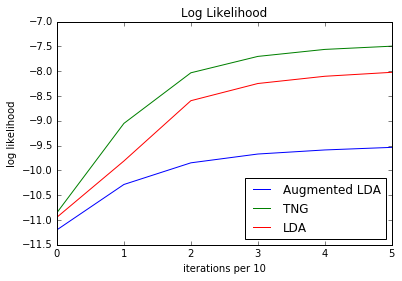

In [42]:

plt.plot(x,y_alda)
plt.plot(x,y_tng)
plt.plot(x,y_lda)
plt.xlabel('iterations per 10')
plt.ylabel('log likelihood')
plt.rcParams['figure.figsize']=(15,8.0) 
plt.title('Log Likelihood')
plt.legend(['Augmented LDA', 'TNG','LDA'], loc='lower right')
plt.savefig('likelihood.png')